# Conceive an app for the Public Health Agency - Data Cleaning

Intro

In [1]:
#! usr/bin/env python 3
# coding: utf-8

# Importing librairies

import numpy as np                # linear algebra
import pandas as pd               # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp                # numerical integration, interpolation, optimization, linear algebra, and statistics
import seaborn as sns             # statistical data visualization
import matplotlib.pyplot as plt   # static, animated, and interactive visualizations in Python

__PRE-PROCESSING OF THE INPUT FILE__

In [4]:
# Split of the .csv file in 4 chunks as not readable directly: chunksize = total file size / 4 (arbitrary)

filename = r"D:\Formation Data Scientist\P3_Lanchec_Stephane\en.openfoodfacts.org.products.csv"

for i, chunk in enumerate(pd.read_csv(filename, sep='\t', low_memory=False, chunksize=462936)):
    chunk.to_csv('chunk{}.csv'.format(i+1), index=False)


__DATAFRAMES CREATION__

In [5]:
chunk1 = r"D:\Formation Data Scientist\P3_Lanchec_Stephane\chunk1.csv"
df_chunk1 = pd.read_csv(chunk1, low_memory=False)
chunk2 = r"D:\Formation Data Scientist\P3_Lanchec_Stephane\chunk2.csv"
df_chunk2 = pd.read_csv(chunk2, low_memory=False)
chunk3 = r"D:\Formation Data Scientist\P3_Lanchec_Stephane\chunk3.csv"
df_chunk3 = pd.read_csv(chunk3, low_memory=False)
chunk4 = r"D:\Formation Data Scientist\P3_Lanchec_Stephane\chunk4.csv"
df_chunk4 = pd.read_csv(chunk4, low_memory=False)

__RECONSTRUCTION OF A TOTAL DATAFRAME FROM THESE SUBDATAFRAMES__

In [6]:
frames = [df_chunk1, df_chunk2, df_chunk3, df_chunk4]
df_factsfood = pd.concat(frames)
df_factsfood.to_csv(r"D:\Formation Data Scientist\P3_Lanchec_Stephane\factsfood.csv")

__FEW FONCTIONS DEFINED TO HELP DESCRIBING THE CHARACTERISTICS OF THE INPUT FILES__

In [7]:
def duplicates (data):
    """Calculate the number of duplicates in dataframe data"""
    
    return len(data)-len(data.drop_duplicates())


def missing_cells (data):
    """Calculate the number of empty cells in dataframe data"""
    
    return data.isna().sum().sum()


def missing_cells_percent (data):
    """Calculate the percentage of empty cells in dataframe data""" 
    
    return missing_cells(data)/(data.size)*100
    

def filled_cells (data):
    """Calculate the number of existing values in dataframe data"""
    
    return data.notna().sum()  
    

def filled_cells_percent (data):
    """Calculate the percentage of existing values in dataframe data"""
    
    return filled_cells(data)/(len(data.index))*100


In [8]:
from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline', font-weight: bold").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

__CREATION OF A DATAFRAME SUMMARIZING KEY INFO FROM THE INPUT FILES__

In [9]:
# Overview of the main characteristics of the dataframe

file_spec = [['Total rows', len(df_factsfood)], ['Total columns', len(df_factsfood.columns)], ['Total duplicates', duplicates(df_factsfood)],
       ['Total Missing cells', missing_cells(df_factsfood)], ['Missing cells (%)', missing_cells_percent(df_factsfood)]]

# Creates Dataframe df_files_spec

df_file_spec = pd.DataFrame(file_spec, columns = ['Characteristics', 'File'])
df_file_spec['File'] = df_file_spec['File'].apply(lambda x: '{:.0f}'.format(x))
df_file_spec

,Characteristics,File
0,Total rows,1851742
1,Total columns,186
2,Total duplicates,1
3,Total Missing cells,274420669
4,Missing cells (%),80


__FIILING RATE OF THE DIFFERENT CATEGORIES IN OUR INPUT FILE__

In [10]:
# Exploration of the existing data in each of the 186 columns

percent_existing = df_factsfood.notnull().sum() * 100 / len(df_factsfood)
existing_data_df = pd.DataFrame({'Column label': df_factsfood.columns,
                                 'Existing data pct': percent_existing})
existing_data_df.reset_index(drop=True, inplace=True)
existing_data_df.sort_values('Existing data pct', ascending=False, inplace=True)
existing_data_df.index = np.arange(1, len(existing_data_df)+1)
existing_data_df['Existing data pct'] = existing_data_df['Existing data pct'].astype(float, errors = 'raise')
existing_data_df1 = existing_data_df.head(5).append(existing_data_df.tail(5))
round(existing_data_df1, 2)

,Column label,Existing data pct
1,code,100.0
2,last_modified_datetime,100.0
3,states,100.0
4,states_tags,100.0
5,states_en,100.0
182,ingredients_from_palm_oil,0.0
183,no_nutriments,0.0
184,allergens_en,0.0
185,cities,0.0
186,ingredients_that_may_be_from_palm_oil,0.0


__DATA CLEANING: 1st PHASE - THRESHOLD ON FILLING RATE IMPOSED ON OUR DATASET__

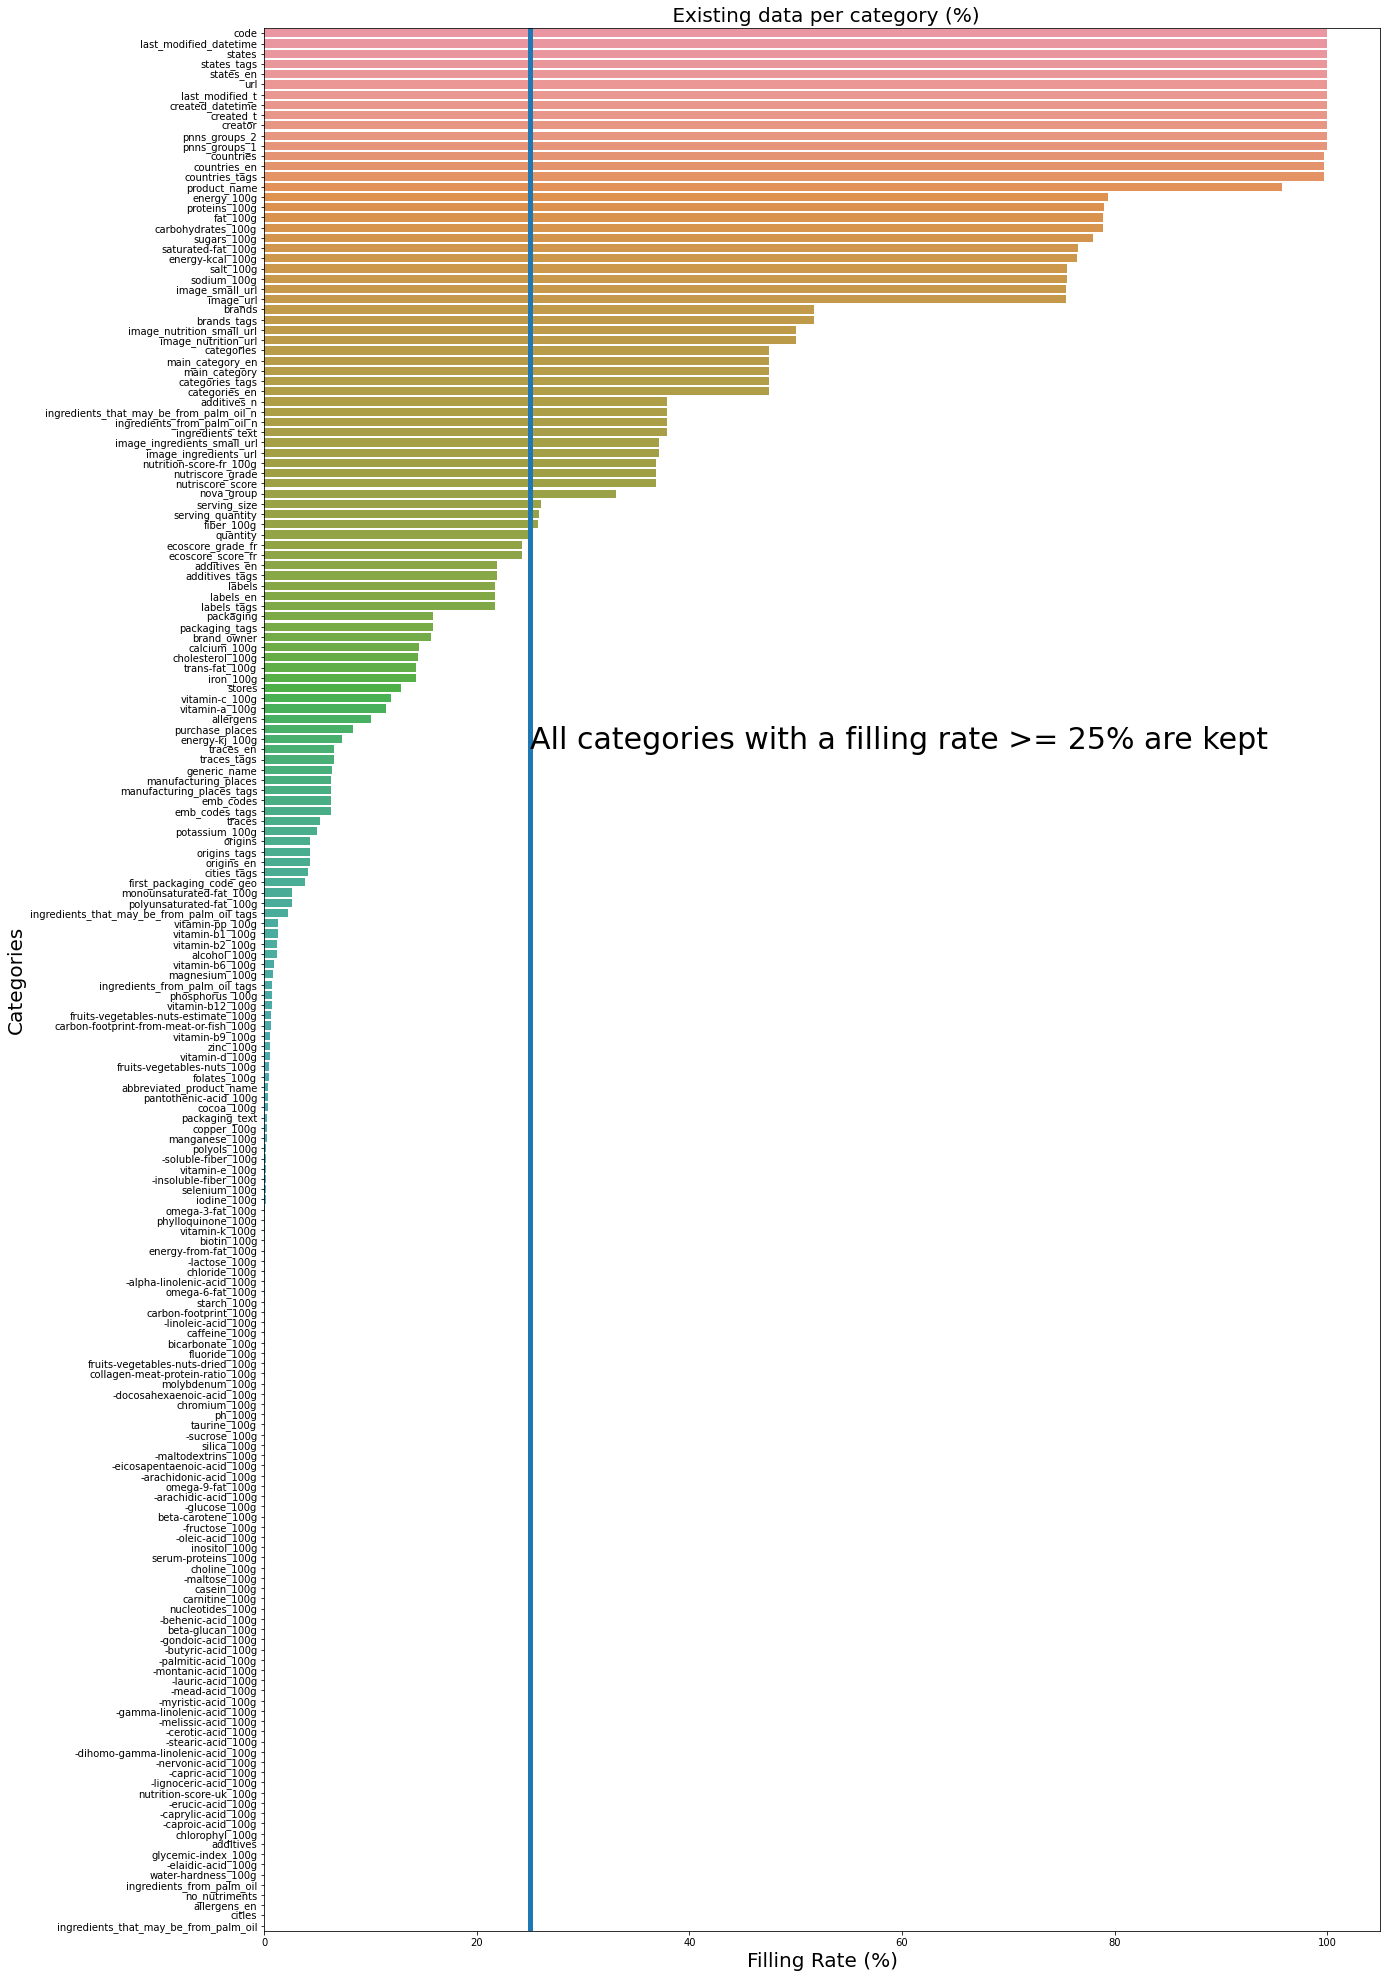

In [11]:
# Threshold input
limitPer = 25
fig = plt.figure(figsize=(20, 35))
font_title = {'weight': 'bold', 'size': 30} 

sns.barplot(x="Existing data pct", y="Column label", data=existing_data_df) 
plt.axvline(x=limitPer, linewidth=5)
plt.text(limitPer, 70, 'All categories with a filling rate >= 25% are kept ', fontsize = 30) 
plt.title(" Existing data per category (%)", fontsize = 20) 
plt.xlabel("Filling Rate (%)", fontsize = 20)
plt.ylabel("Categories", fontsize = 20)
plt.show()

In [12]:
limitPer = 0.24
Filter = len(df_factsfood) * limitPer
df_data1 = df_factsfood.dropna(thresh=Filter, axis=1)
#df_data1.shape

__DATA CLEANING: 2nd PHASE - FOCUS ON ENTRIES WITH NUTRISCORE AVAILABLE__

In [13]:
df_nutrifrance = df_data1.dropna(axis=0, subset=['nutriscore_score', 'nutriscore_grade'])
df_nutrifrance.shape

(681833, 52)

__OVERVIEW OF INPUT ITEMS PER COUNTRY__

In [14]:
# List of all the countries that have products data
# Some creators input strings of countries that we need to split into individual countries
# Before split

pays_counts1 = df_nutrifrance['countries_en'].value_counts(dropna=True, sort=True)
df_pays_counts1 = pd.DataFrame(pays_counts1)
df_pays_counts1.index.name = 'Countries'
df_pays_counts1.columns = ['Number of records']
df_pays_counts_rec1 = df_pays_counts1.head(5).append(df_pays_counts1.tail(5))

# Split
df_country = df_nutrifrance.drop('countries_en', axis=1).join(df_nutrifrance['countries_en'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('Countries'))
df_countries = df_country.drop_duplicates()

# After split
pays_counts2 = df_countries['Countries'].value_counts(dropna=True, sort=True)
df_pays_counts2 = pd.DataFrame(pays_counts2)
df_pays_counts2.index.name = 'Countries'
df_pays_counts2.columns = ['Number of records']
df_pays_counts_rec2 = df_pays_counts2.head(5).append(df_pays_counts2.tail(5))

display_side_by_side([df_pays_counts_rec1, df_pays_counts_rec2], ['Before split', 'After split'])

,Number of records
Countries,
France,246711
United States,234646
Spain,51527
Germany,29778
Italy,11730
"France,Germany,Italy,Luxembourg,Switzerland",1
"France,Germany,Italy,Portugal,Spain,Switzerland",1
"French Polynesia,United Kingdom",1
"China,France,Switzerland",1


__DATA CLEANING: 3rd PHASE - FOCUS ON FRANCE DATA__

In [15]:
df_france = df_countries[df_countries['Countries'].str.contains('France', na=False)] 
df_france.shape

(480625, 52)

In [16]:
df_nutrifrance1 = df_france.dropna(axis=0, subset=['nutriscore_score', 'nutriscore_grade'])
df_nutrifrance1.shape

(480625, 52)

__DATA CLEANING: 4th PHASE - REMOVE NOT CRITICAL OR REDUNDANT FEATURES__ 

In [17]:
# Few columns represent the same feature with more or less details
col_names = ['categories_en', 'categories', 'categories_tags', 'main_category', 'main_category_en', 'pnns_groups_1', 'pnns_groups_2', ]

# Select multiple columns of dataframe by names in list
multiple_columns = df_france[col_names]
df_catego = pd.DataFrame(multiple_columns)
df_catego.head(5)

,categories_en,categories,categories_tags,main_category,main_category_en,pnns_groups_1,pnns_groups_2
0,"Beverages,Carbonated drinks,Sodas","Beverages, Carbonated drinks, Sodas","en:beverages,en:carbonated-drinks,en:sodas",en:sodas,Sodas,Beverages,Sweetened beverages
0,"Dairies,Fermented foods,Fermented milk product...","Produits laitiers, Produits fermentés, Produit...","en:dairies,en:fermented-foods,en:fermented-mil...",en:sweetened-yogurts,Sweetened yogurts,Milk and dairy products,Milk and yogurt
0,"Biscuits and cakes,Cakes,Muffins,Chocolate cak...","Kekse und Kuchen, Kuchen, Muffins, Schokoladen...","en:biscuits-and-cakes,en:cakes,en:muffins,en:c...",en:chocolate-muffins,Chocolate muffins,Sugary snacks,Biscuits and cakes
1,"Beverages,Carbonated drinks,Sodas","Beverages, Carbonated drinks, Sodas","en:beverages,en:carbonated-drinks,en:sodas",en:sodas,Sodas,Beverages,Sweetened beverages
1,"Dairies,Fermented foods,Fermented milk product...","Produits laitiers, Produits fermentés, Produit...","en:dairies,en:fermented-foods,en:fermented-mil...",en:sheep-milk-yogurts,Sheep milk yogurts,Milk and dairy products,Milk and yogurt


__ZOOM ON THE MORE GENERIC PNNS GROUPS__

In [18]:
# PNNS Groups are more generic categories than the others
# PNNS Group 1 is the main category with PNNS Group 2 being a subcategory

cat_counts1 = df_catego['pnns_groups_1'].value_counts(dropna=True, sort=True)

df_cat_counts1 = pd.DataFrame(cat_counts1)
df_cat_counts1.index.name = 'Categories'
df_cat_counts1.columns = ['Number of records']
df_cat_counts1a = df_cat_counts1.append(df_cat_counts1.sum().rename('Total'))

cat_counts2 = df_catego['pnns_groups_2'].value_counts(dropna=True, sort=True)

df_cat_counts2 = pd.DataFrame(cat_counts2)
df_cat_counts2.index.name = 'Categories'
df_cat_counts2.columns = ['Number of records']
df_cat_counts2a = df_cat_counts2.append(df_cat_counts2.sum().rename('Total'))

display_side_by_side([df_cat_counts1a, df_cat_counts2a], ['pnns Group 1', 'pnns Group 2'])

,Number of records
Categories,
Sugary snacks,86164
unknown,67040
Fish Meat Eggs,62291
Milk and dairy products,57487
Cereals and potatoes,48444
Composite foods,37415
Fat and sauces,36180
Beverages,30484
Fruits and vegetables,28402


In [19]:
# Comparison test for 2 columns Nutrition Score: If True, we remove one of them
df_nutrifrance['nutriscore_score'].equals(df_nutrifrance['nutrition-score-fr_100g'])

True

__NOT CRITICAL COLUMNS__

In [20]:
df_cat = df_france.drop(['categories', 'categories_tags', 'categories_en', 'countries', 'countries_tags', 'main_category', 'main_category_en',
                              'creator', 'created_t', 'created_datetime', 'last_modified_t', 'nutrition-score-fr_100g',
                              'last_modified_datetime', 'brands', 'brands_tags', 'serving_size',
                              'serving_quantity', 'states', 'states_tags', 'states_en'],
                               axis=1)
df_cat.drop_duplicates()
df_cat.to_csv('cleaning1.csv')
df_cat

,code,url,product_name,quantity,ingredients_text,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutriscore_score,nutriscore_grade,...,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,Countries
0,0861292000082,http://world-en.openfoodfacts.org/product/0861...,"Black cherry cola coffee soda, black cherry cola",NaN,"Organic cold brew concentrate (filtered water,...",1.0,0.0,0.0,8.0,d,...,105.0,0.00,0.00,5.83,5.42,0.0,0.42,0.0050,0.002,France
0,3564707119610,http://world-en.openfoodfacts.org/product/3564...,Yaourt au lait entier bio à la noix de coco,4 x 125 g,"Lait entier* (origine : France) 88%, sucre de ...",0.0,0.0,0.0,2.0,b,...,382.0,3.10,1.90,12.00,12.00,0.0,3.70,0.1000,0.040,France
0,7310100550798,http://world-en.openfoodfacts.org/product/7310...,Mini Muffins Chocolate,185 g,ZUTATEN: Füllung mit Schokoladengeschmack 27% ...,6.0,0.0,0.0,23.0,e,...,1841.0,24.00,9.60,50.00,30.00,NaN,4.40,0.7000,0.280,France
1,0861292000099,http://world-en.openfoodfacts.org/product/0861...,"Citrus vanilla cream coffee soda, citrus vanil...",NaN,"Organic cold brew concentrate (filtered water,...",1.0,0.0,0.0,6.0,d,...,88.0,0.00,0.00,5.42,4.17,0.0,0.42,0.0050,0.002,France
1,3564707119658,http://world-en.openfoodfacts.org/product/3564...,Yaourt au lait de brebis sur lit de myrtilles bio,2 x 125 g,"Lait entier de brebis* (origine : France) 80%,...",1.0,0.0,0.0,4.0,c,...,503.0,5.00,3.60,14.00,12.00,0.9,4.30,0.1000,0.040,France
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462932,3564707119221,http://world-en.openfoodfacts.org/product/3564...,Crackers emmental et graines de courge bio,200 g,"Farine complète de blé* 57%, emmental* 13%, gr...",0.0,0.0,0.0,11.0,d,...,1851.0,18.00,4.90,47.00,2.60,10.0,18.00,1.8000,0.720,France
462934,0861290000169,http://world-en.openfoodfacts.org/product/0861...,"Cherry almond chunk granola truffles, cherry a...",NaN,"*dark chocolate (*sugar, *chocolate liquor, *c...",1.0,0.0,0.0,16.0,d,...,1971.0,23.53,14.71,58.82,29.41,5.9,5.88,0.1475,0.059,France
462934,3564707119535,http://world-en.openfoodfacts.org/product/3564...,Yaourt brassé à la mangue et à la vanille bio ...,4 x 125 g,"Lait entier* (origine : France) 78%, mangue* 1...",0.0,0.0,0.0,2.0,b,...,369.0,2.90,1.80,12.00,12.00,0.0,3.30,0.1000,0.040,France
462935,0861291000007,http://world-en.openfoodfacts.org/product/0861...,French hillbilly pickled green beans,NaN,"White vinegar, water, green beans, lemon juice...",0.0,0.0,0.0,8.0,c,...,749.0,0.00,0.00,7.14,3.57,0.0,0.00,1.4275,0.571,France


__SUMMARY OF DATA CLEANING PHASES__

In [21]:
file_redu = [['Input file', df_factsfood.shape], ['Phase 1', df_data1.shape],
             ['Phase 2', df_nutrifrance.shape], ['Phase 3', df_france.shape],
             ['Phase 4', df_cat.shape]]

# Creates Dataframe df_files_redu

df_file_redu = pd.DataFrame(file_redu, columns = ['Data cleaning', 'DataFrame shape'])
df_file_redu = df_file_redu.set_index('Data cleaning')
df_file_redu

,DataFrame shape
Data cleaning,
Input file,"(1851742, 186)"
Phase 1,"(1851742, 52)"
Phase 2,"(681833, 52)"
Phase 3,"(480625, 52)"
Phase 4,"(480625, 32)"
